In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

JAK_INHIBITORS = False

data_dir = "../data/09242025_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))
column_to_stain = dict(zip(range(1,13), ["pSTAT"]*12))
column_to_stain = dict(zip(range(1,13), ["Old"]*3 + ["New"]*9))

row_to_patient = {
	#"A":813,
	"B":826,
	"C":826,
	"D":905,
	"E":905,
	#"F":905,
	#"G":905,
	#"H":617
}	

column_to_t_pts = {
	1:0,
	2:15,
	3:20,
	4:15,
	5:15,
	6:15,
	7:20,
	8:20,
	9:20,
	10:25,
	11:25,
	12:25
}

row_to_replicate = {
	#"A":1,
	"B":1,
	"C":2,
	"D":1,
	"E":2,
	#"F":1,
	#"G":2,
	#"H":1    
}

column_to_dosage = {
	1:0,
	2:10,
	3:10,
	4:5,
	5:10,
	6:20,
	7:5,
	8:10,
	9:20,
	10:5,
	11:10,
	12:20
}


  WellId  Row  Column  ValidObjectCount
0    B01    2       1              3161
1    B02    2       2              2445
2    B03    2       3              4456
3    B04    2       4              5208
4    B05    2       5              6683


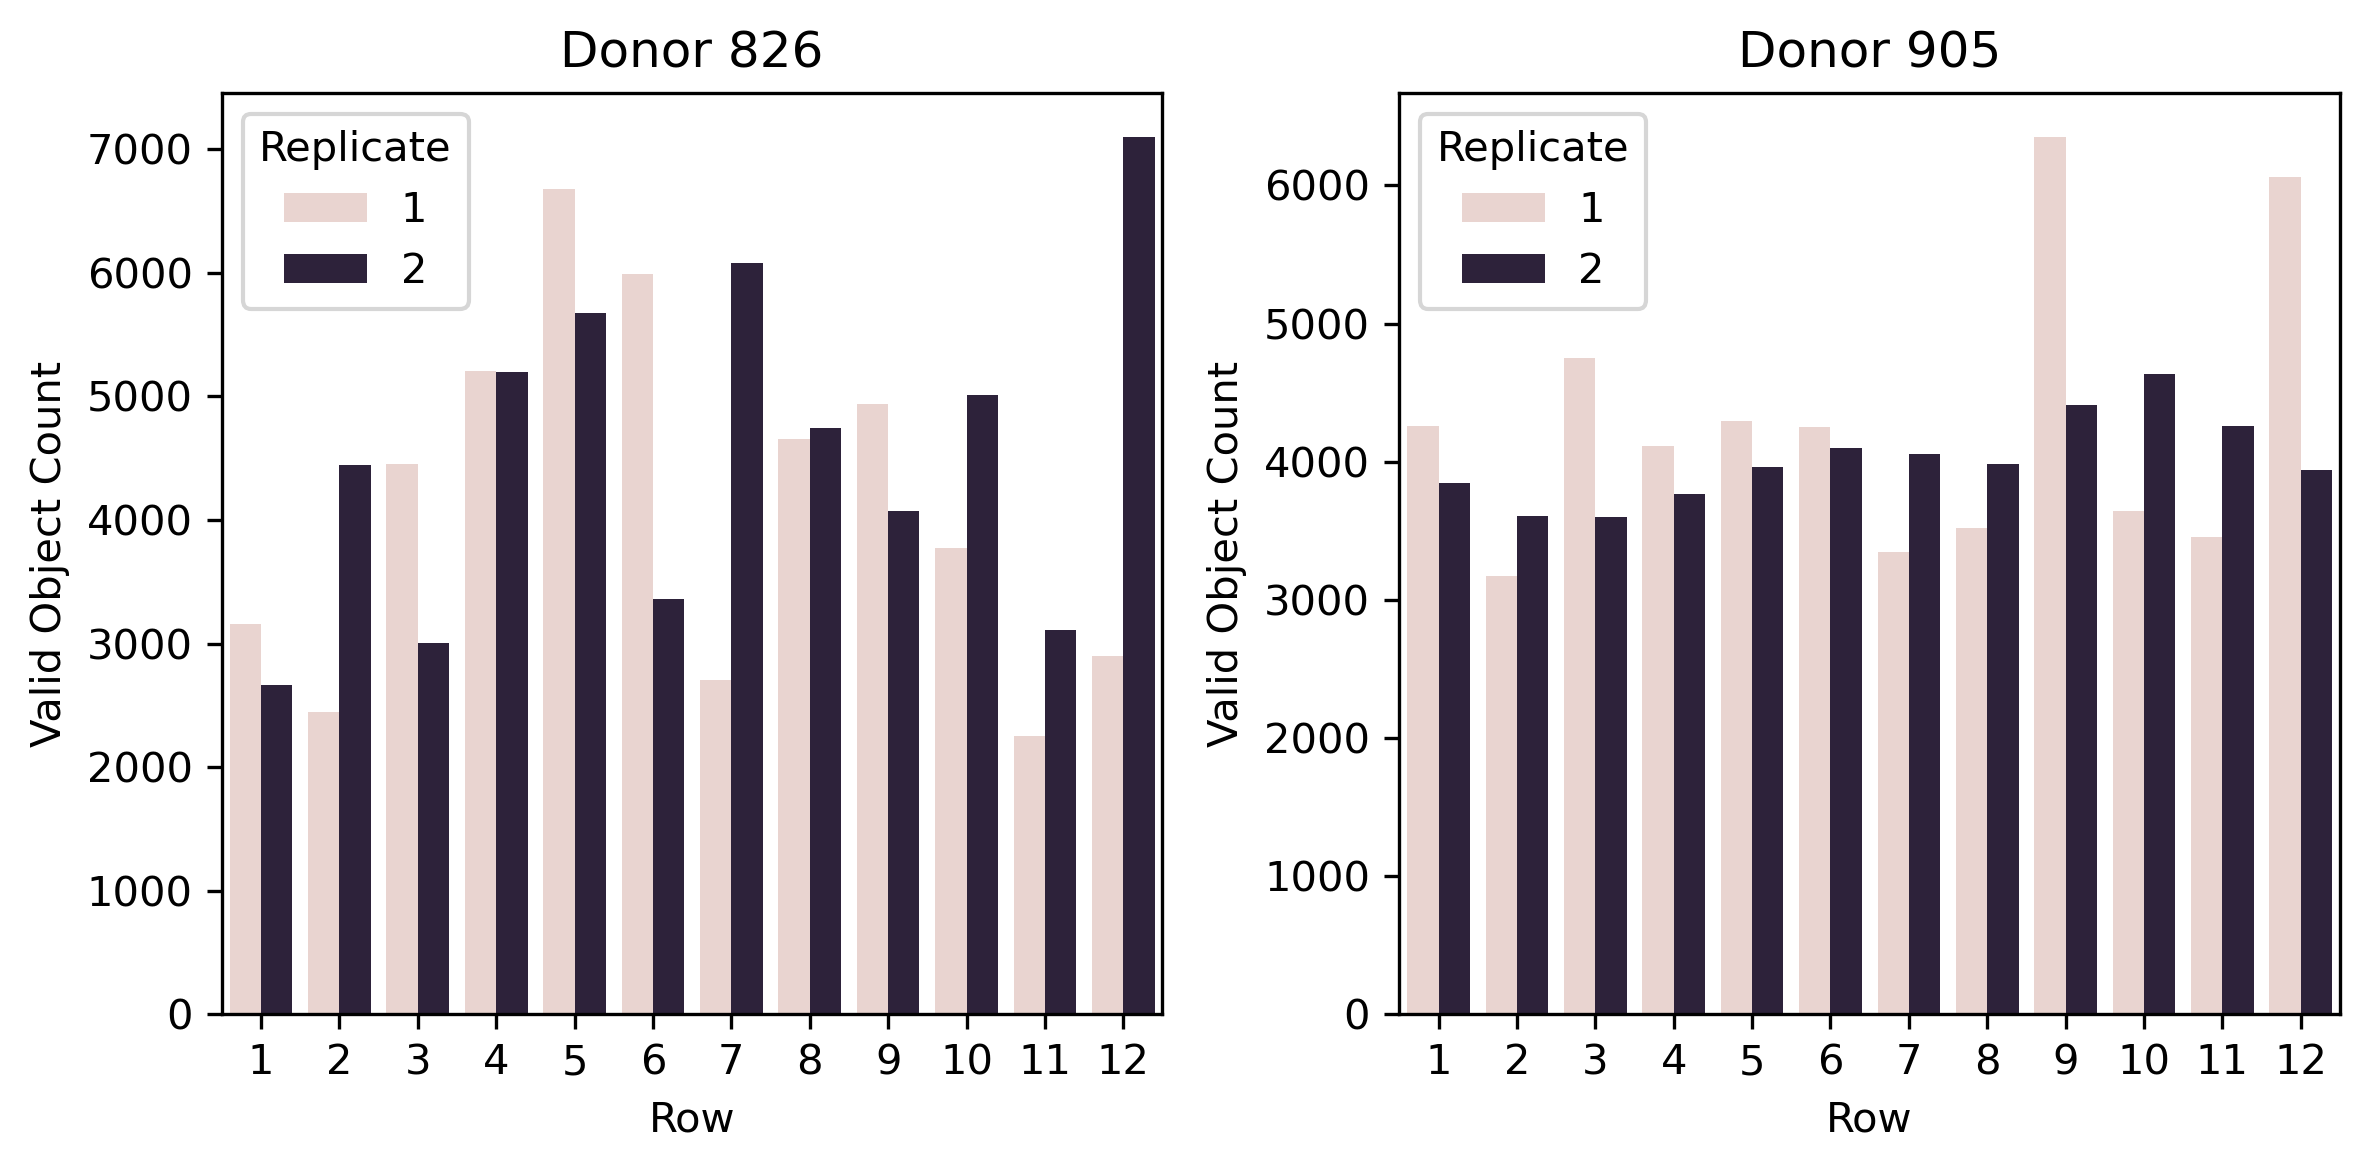

In [ ]:
import string
alpha_dict = dict(zip(range(1,27), string.ascii_uppercase))
full_fname = f"{data_dir}/Well.csv"
select_cols = ["WellId", "Row", "Column", "ValidObjectCount"]
df = pd.read_csv(full_fname, usecols=select_cols)
print(df.head())
df["PatientId"] = [row_to_patient[alpha_dict[x]] for x in df["Row"]]
df["Replicate"] = [row_to_replicate[alpha_dict[x]] for x in df["Row"]]

fig = plt.figure(figsize=(8,4), dpi=300)
for i,pat in enumerate(df["PatientId"].unique()):
	ax = fig.add_subplot(1,2,i+1)
	select_df = df[df["PatientId"] == pat]
	sns.barplot(x="Column", y="ValidObjectCount", hue="Replicate", data=select_df, ax=ax)
	ax.set_title(f"Donor {pat}")
	ax.set_xlabel("Row");
	ax.set_ylabel("Valid Object Count");
	ax.legend(title="Replicate")
plt.tight_layout(); 

In [ ]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].std()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].std()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]
	stat_df.index = [x.strip() for x in stat_df.index]
	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = [column_to_dosage[x] for x in cols]
	stat_df["Time"] = [column_to_t_pts[x] for x in cols]
	stat_df["Replicate"] = [row_to_replicate[x] for x in rows]
	stat_df["Date"] = data_dir.split("/")[-1]
	display(stat_df)
	stat_df.to_csv(f"{data_dir.split('/')[-1]}.csv")
	dfs.append(stat_df)

,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate,Date
B01,4.203440e+06,1.495849e+06,2.981665e+06,3.135618e+06,Old,826,0,0,1,09242025_IF_scan
B02,4.246251e+06,1.067800e+06,4.967736e+06,2.068961e+06,Old,826,10,15,1,09242025_IF_scan
B03,3.961015e+06,8.957112e+05,3.579504e+06,1.257446e+06,Old,826,10,20,1,09242025_IF_scan
B04,4.147996e+06,1.030889e+06,3.110507e+06,1.079465e+06,New,826,5,15,1,09242025_IF_scan
B05,4.457696e+06,1.385378e+06,2.838799e+06,1.057553e+06,New,826,10,15,1,09242025_IF_scan
B06,4.571837e+06,1.335391e+06,3.025178e+06,1.107497e+06,New,826,20,15,1,09242025_IF_scan
B07,1.156776e+07,5.816038e+06,1.625979e+07,6.533134e+06,New,826,5,20,1,09242025_IF_scan
B08,5.332598e+06,1.542404e+06,3.633507e+06,1.364899e+06,New,826,10,20,1,09242025_IF_scan
B09,6.182187e+06,2.565636e+06,3.627416e+06,1.424642e+06,New,826,20,20,1,09242025_IF_scan
B10,6.410245e+06,2.042712e+06,3.320837e+06,1.174788e+06,New,826,5,25,1,09242025_IF_scan


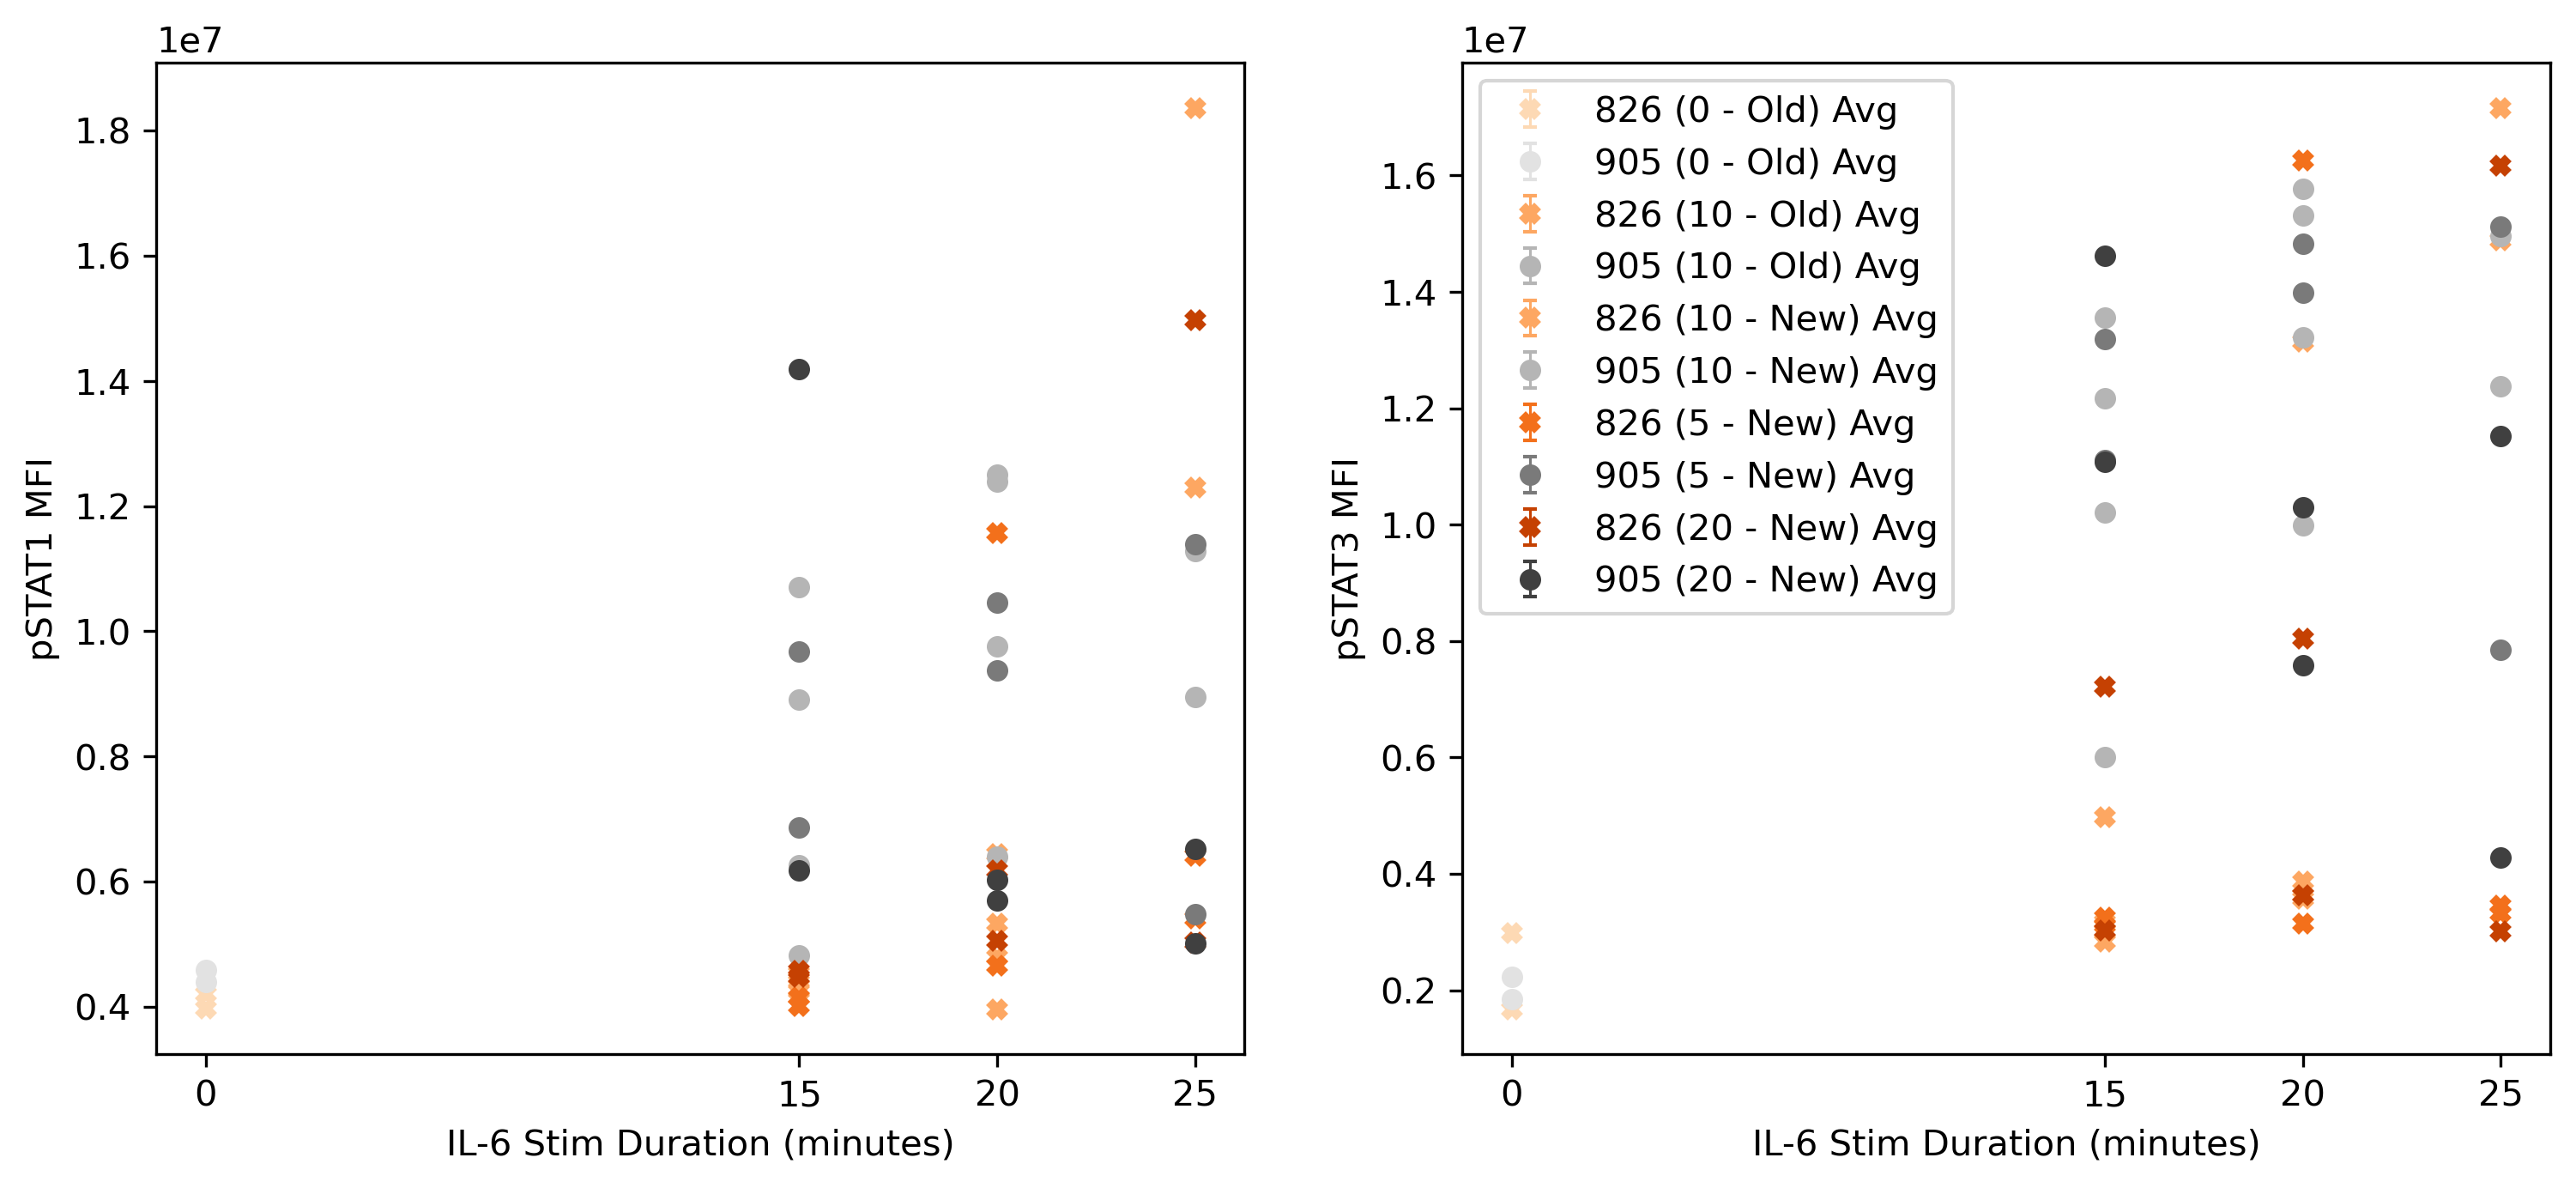

In [ ]:
def create_color_pal(pat_id, n_doses):

	patient_to_palette = {
		617: "Reds",
		626: "Blues",
		813: "Greens",
		826: "Oranges",
		904: "Purples",
		905: "Greys"
	}
	return sns.color_palette(patient_to_palette[pat_id], n_doses)


patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"X",
	904:"P",
	905:"o"
}

fig1, axs = plt.subplots(1,2, figsize=(12,5), dpi=300)

df = dfs[0]
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)

ms=5
stat1_ax = axs[0]
stat3_ax = axs[1]
for typ in df["STAT"].unique():
	n_doses = len(df["IL-6 Concentration"].unique())
	for dosage in df["IL-6 Concentration"].unique():
		
		for pat in df["PatientId"].unique():

			# Get color palette
			cmap = create_color_pal(pat, n_doses)
			cdict = dict(zip(df["IL-6 Concentration"].unique(), cmap))
			cur_df = df.loc[(df["PatientId"] == pat) & (df["IL-6 Concentration"] == dosage) & (df["STAT"] == typ)]
			if cur_df.empty:
				continue
			#stat1_ax.plot(cur_df["IL-6 Concentration"].unique(), cur_df.groupby("IL-6 Concentration")["STAT1 Mean"].mean(),
			#				marker="none", color=cdict[dosage],
			#				lw=1, label=label)

			#stat3_ax.plot(cur_df["IL-6 Concentration"].unique(), cur_df.groupby("IL-6 Concentration")["STAT3 Mean"].mean(),
			#				marker="none", color=cdict[dosage], 
			#				lw=1, label=label)

			#for il6 in df["IL-6 Concentration"].unique():
			for rep in df["Replicate"].unique():
				select_df = df.loc[(df["PatientId"] == pat) & (df["IL-6 Concentration"] == dosage) & (df["STAT"] == typ) & (df["Replicate"]== rep)]
				if select_df.empty:
					continue
				label = f"{pat} ({dosage} - {typ}) Avg"
				if rep > 1:
					label=None
				stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=cdict[dosage],
							ls="none",
							lw=0.75, label=label, capsize=2)
				
				stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=cdict[dosage],
							ls="none", 
							lw=0.75,  label=label, capsize=2)
		stat1_ax.set_ylabel("pSTAT1 MFI")
		stat1_ax.set_xlabel("IL-6 Stim Duration (minutes)")
		stat3_ax.set_ylabel("pSTAT3 MFI")
		stat3_ax.set_xlabel("IL-6 Stim Duration (minutes)")
	stat1_ax.set_xticks(df["Time"].unique())
	stat3_ax.set_xticks(df["Time"].unique());
	#stat1_ax.legend();
	stat3_ax.legend();

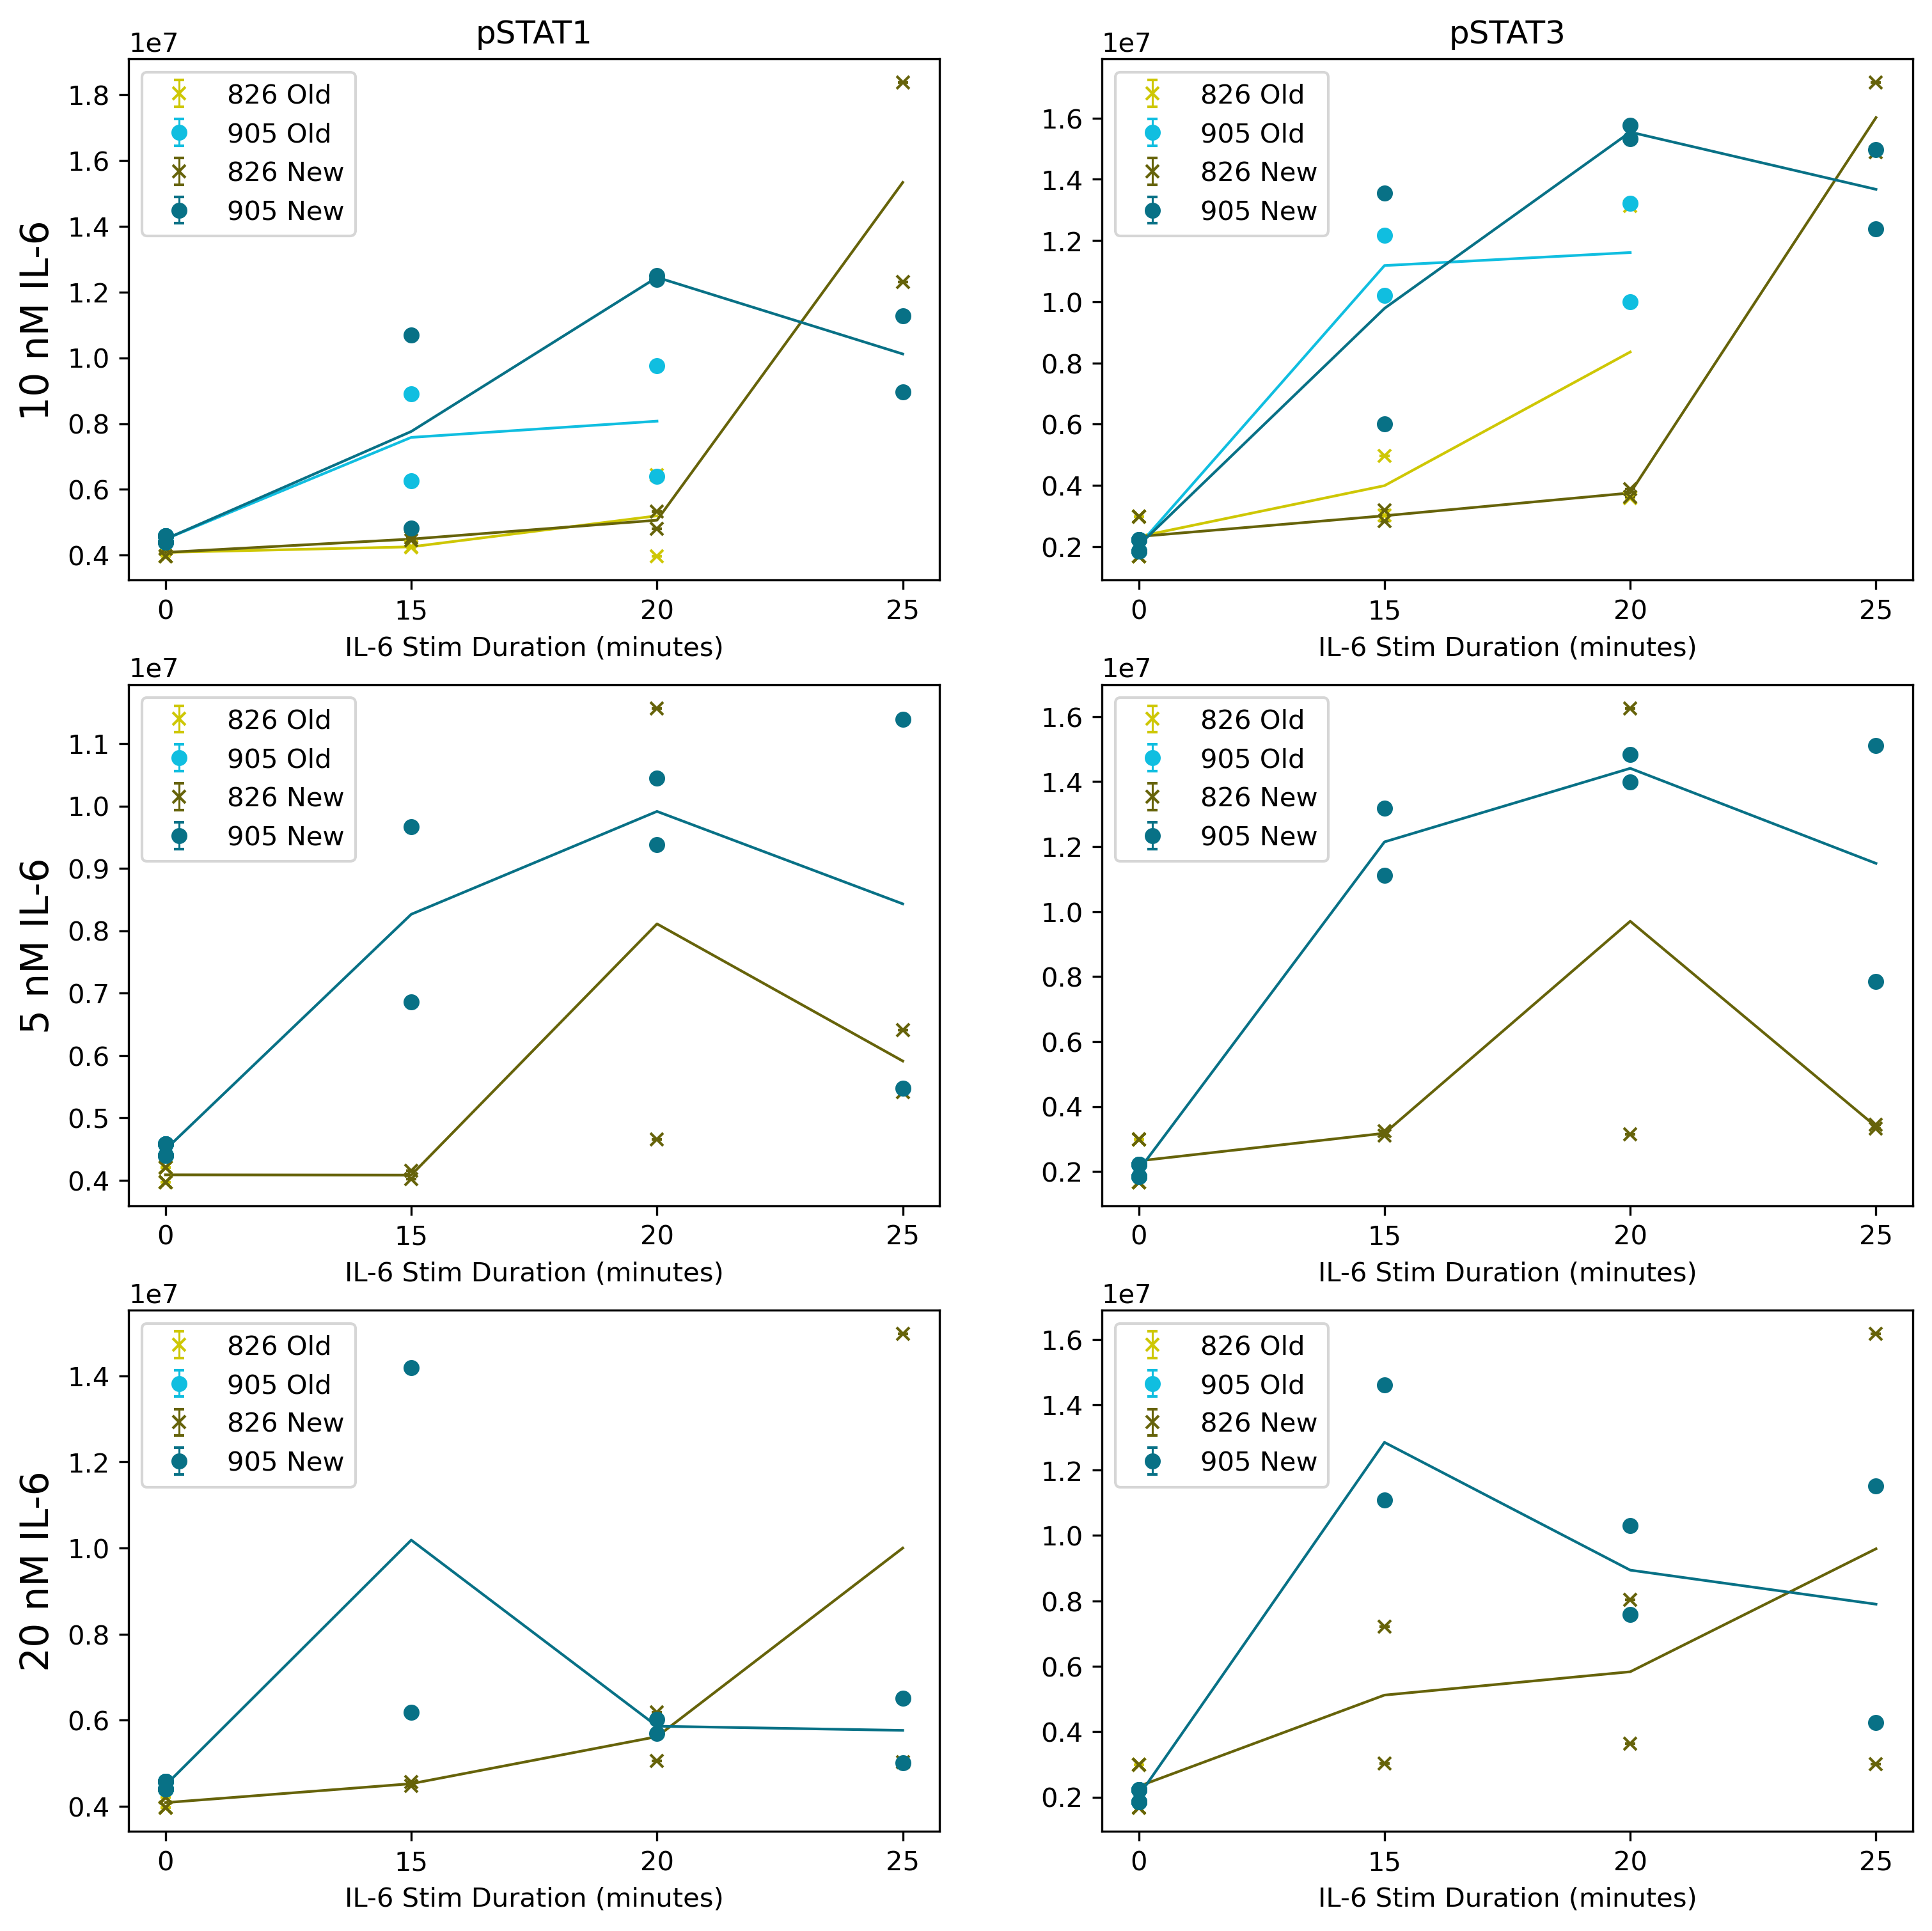

In [121]:
import random

def generate_random_colors(n):
	"""
	Generates a list of n random RGB color tuples.
	Each color is represented as a tuple (r, g, b) where r, g, and b are
	integers between 0 and 255 (inclusive).
	"""
	colors = []
	for _ in range(n):
		r = random.randint(0, 255)/255.0
		g = random.randint(0, 255)/255.0
		b = random.randint(0, 255)/255.0
		colors.append((r, g, b))
	return colors

patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"x",
	904:"P",
	905:"o"
}

fig1, axes = plt.subplots(3,2, figsize=(12,12), dpi=300)

df = dfs[0]
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)

ms=5
stat1_axes = axes[:, 0]
stat3_axes = axes[:, 1]

color_dict = {
	826: {
		"Old":"#cec704",
		"New":"#66630a"
	},
	905: {
		"Old":"#10bee0",
		"New":"#087186"
	}
}

for typ in df["STAT"].unique():
	n_doses = len(df["IL-6 Concentration"].unique())
	for i, dosage in enumerate(df["IL-6 Concentration"].unique()[1:]):
 
		stat1_ax = stat1_axes[i]
		stat3_ax = stat3_axes[i]
		for pat in df["PatientId"].unique():

			# Get color palette
			c = color_dict[pat][typ]
			cur_df = df.loc[(df["PatientId"] == pat) & (((df["IL-6 Concentration"] == dosage) & (df["STAT"] == typ)) | (df["IL-6 Concentration"] == 0))]
			
			if cur_df.empty:
				continue
			stat1_ax.plot(cur_df["Time"].unique().astype(str), cur_df.groupby("Time")["STAT1 Mean"].mean(),
							marker="none", color=c, lw=1)

			stat3_ax.plot(cur_df["Time"].unique().astype(str), cur_df.groupby("Time")["STAT3 Mean"].mean(),
							marker="none", color=c, lw=1)

			#for il6 in df["IL-6 Concentration"].unique():
			for rep in df["Replicate"].unique():
				select_df = df.loc[(df["PatientId"] == pat) & ((df["IL-6 Concentration"] == dosage) | (df["IL-6 Concentration"] == 0))& (df["STAT"] == typ) & (df["Replicate"]== rep)]
				
				if select_df.empty:
					continue
				label = f"{pat} {typ}"
				if rep > 1:
					label=None
				# Plot control wells
				control = df.loc[(df["PatientId"] == pat) & (df["Time"] == 0)]
				
				stat1_ax.errorbar(x=["0"]*control.shape[0], y=control["STAT1 Mean"], yerr=control["STAT1 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", label=None, lw=0.75)
				stat3_ax.errorbar(x=["0"]*control.shape[0], y=control["STAT3 Mean"], yerr=control["STAT3 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", label=None, lw=0.75)
				# Plot data
				stat1_ax.errorbar(x=select_df["Time"].astype(str), y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none",
							lw=0.75, label=label, capsize=2)
				
				stat3_ax.errorbar(x=select_df["Time"].astype(str), y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", 
							lw=0.75,  label=label, capsize=2)
			count+=1
  		#stat1_ax.set_ylabel("pSTAT1 MFI")
		stat1_ax.set_xlabel("IL-6 Stim Duration (minutes)")
		#stat3_ax.set_ylabel("pSTAT3 MFI")
		stat3_ax.set_xlabel("IL-6 Stim Duration (minutes)")
		stat1_ax.set_xticks(np.arange(len(df["Time"].unique())), df["Time"].unique())
		stat3_ax.set_xticks(np.arange(len(df["Time"].unique())), df["Time"].unique());
		stat1_ax.legend();
		stat3_ax.legend();

cols = ["pSTAT1", "pSTAT3"]
for ax, col in zip(axes[0, :], cols):
	ax.set_title(col)

rows = [f"{x} nM IL-6" for x in df["IL-6 Concentration"].unique()[1:]]
for ax, row in zip(axes[:,0], rows):
	ax.set_ylabel(row, rotation=90, size='x-large')

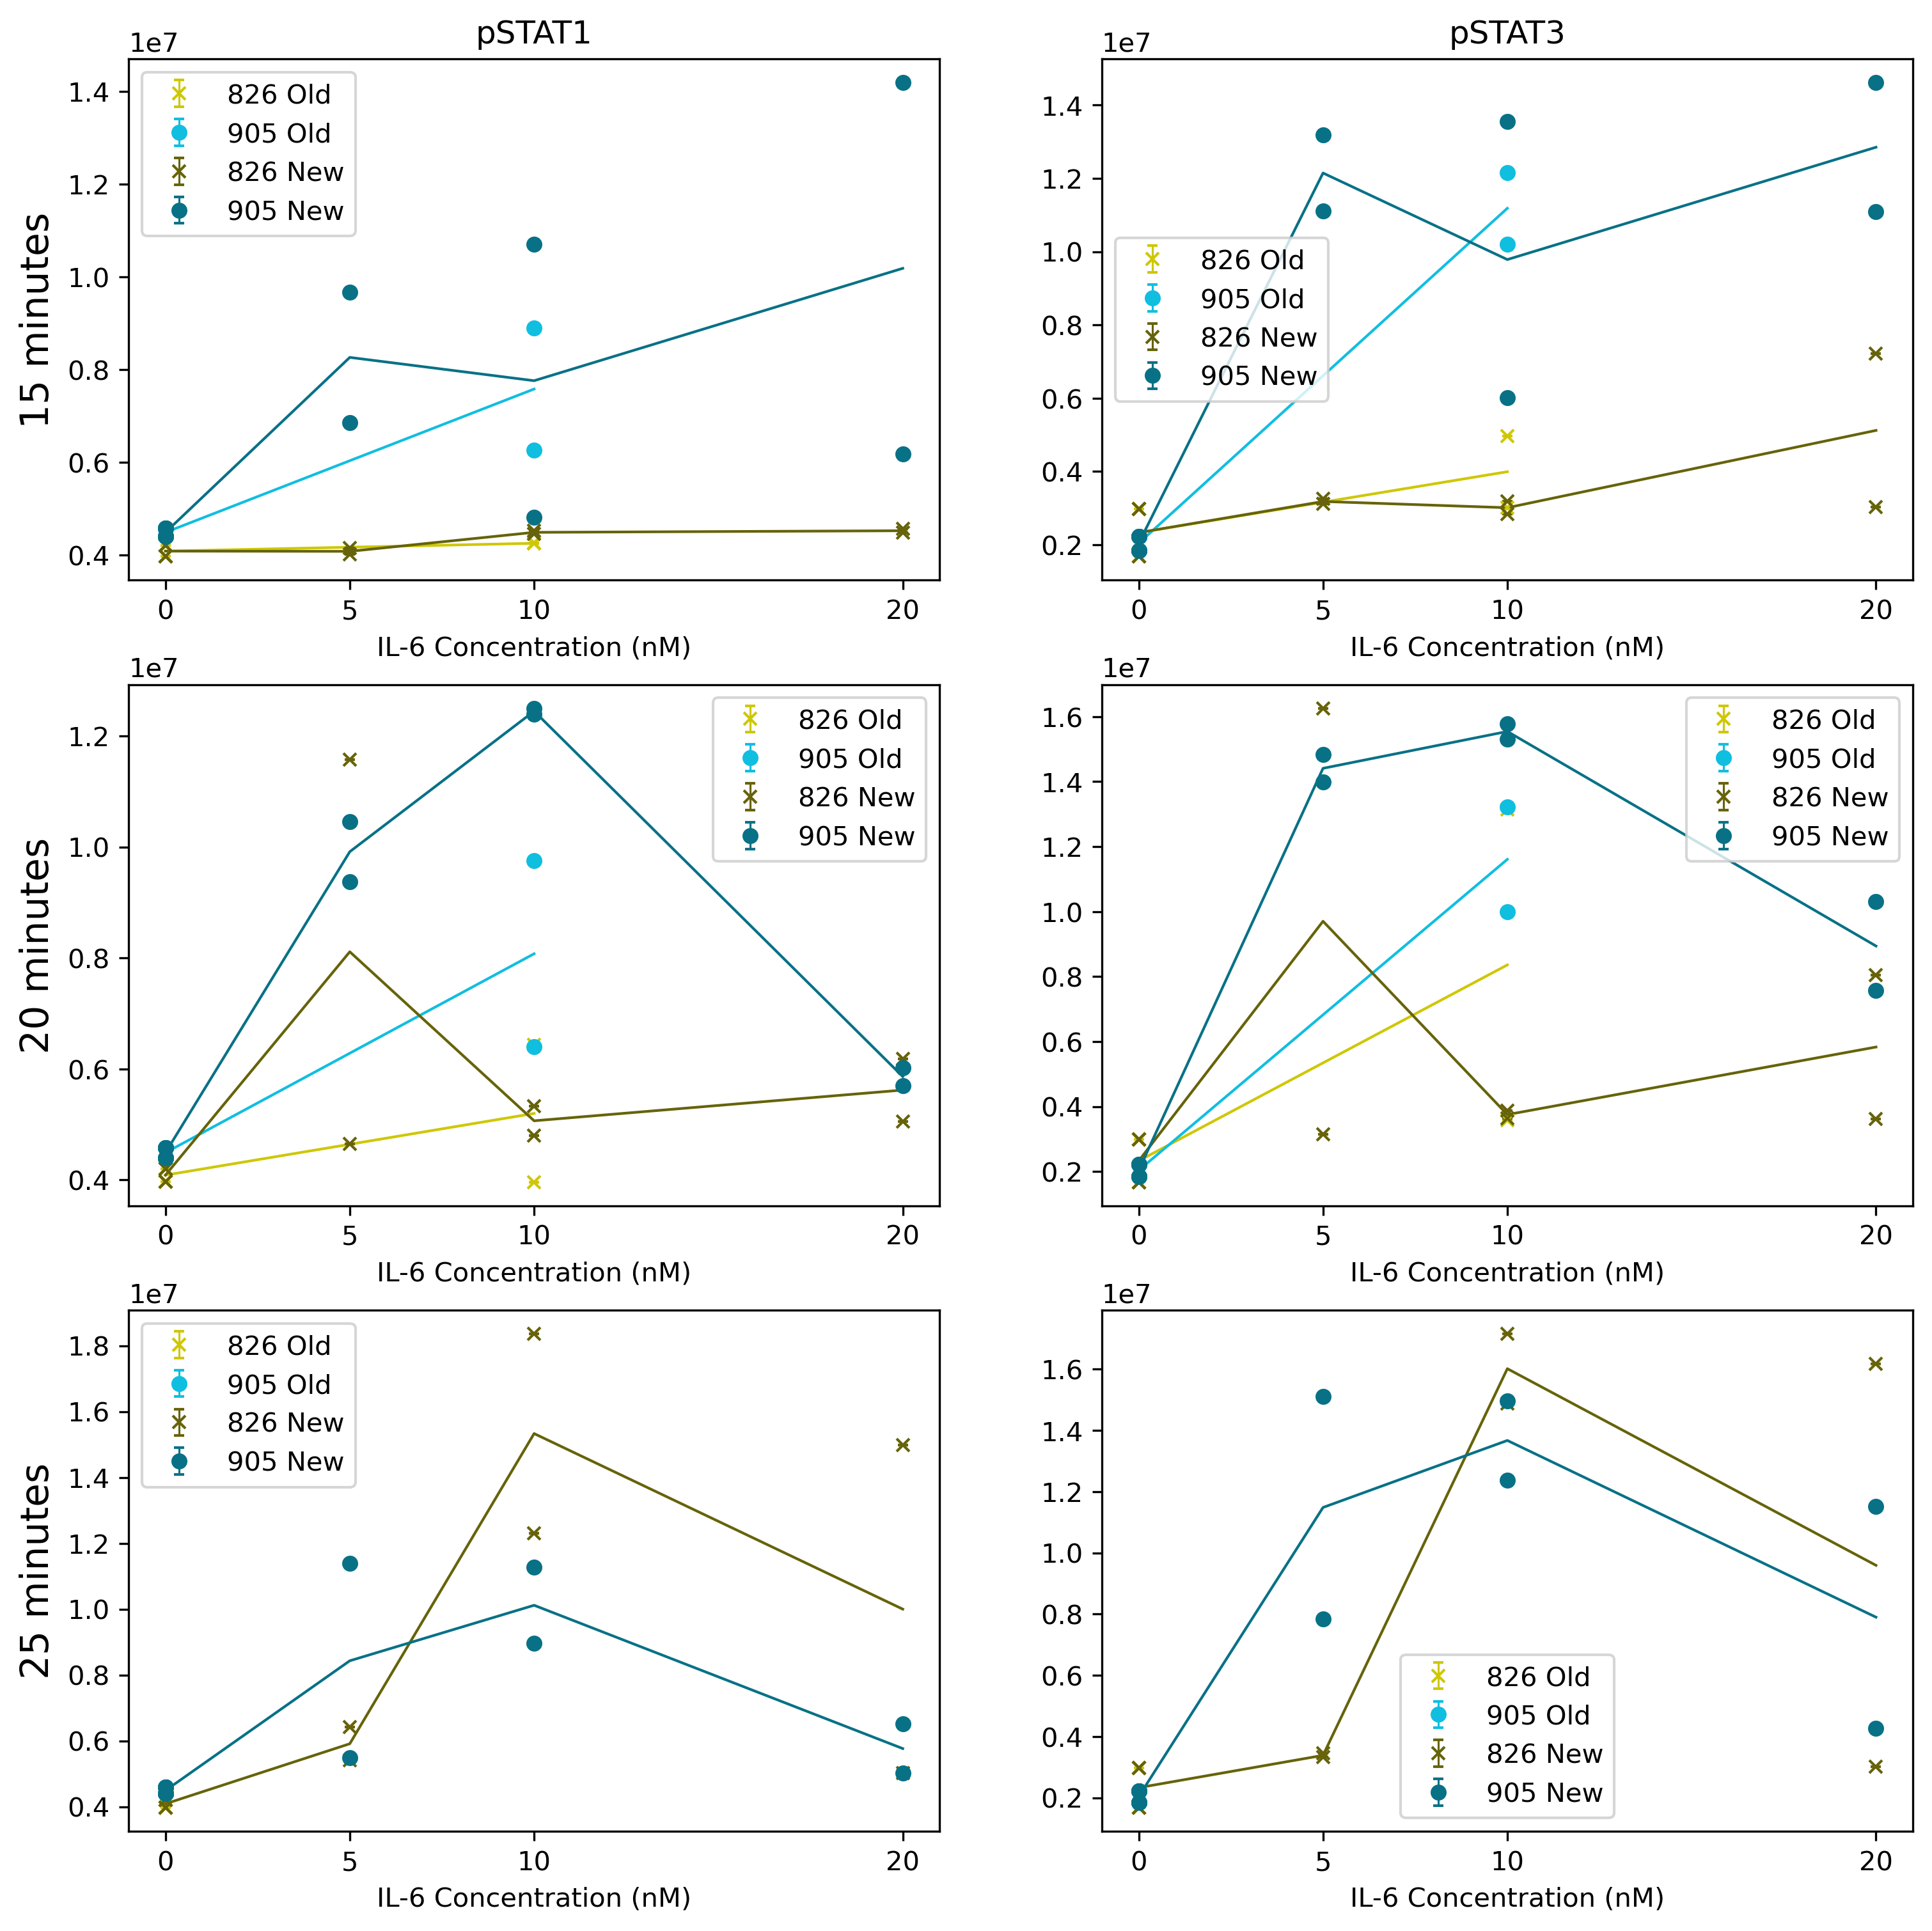

In [122]:
patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"x",
	904:"P",
	905:"o"
}

color_dict = {
	826: {
		"Old":"#cec704",
		"New":"#66630a"
	},
	905: {
		"Old":"#10bee0",
		"New":"#087186"
	}
}

fig1, axes = plt.subplots(3,2, figsize=(12,12), dpi=300)

df = dfs[0]
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)

ms=5
stat1_axes = axes[:, 0]
stat3_axes = axes[:, 1]

df["IL-6 Concentration"] = df["IL-6 Concentration"].astype(int)

for typ in df["STAT"].unique():
	n_ts = len(df["Time"].unique()[1:])
	for i, t in enumerate(df["Time"].unique()[1:]):
		stat1_ax = stat1_axes[i]
		stat3_ax = stat3_axes[i]
		stat1_ax.set_xticks([0, 5, 10, 20], [0, 5, 10, 20])
		stat3_ax.set_xticks([0, 5, 10, 20], [0, 5, 10, 20])
		for pat in df["PatientId"].unique():
			# Get color palette
			c = color_dict[pat][typ]
			cur_df = df.loc[(df["PatientId"] == pat) & (((df["Time"] == t) & (df["STAT"] == typ)) | (df["Time"] == 0))]
			cur_df = cur_df.sort_values(by="IL-6 Concentration")
			
			if cur_df.empty or len(cur_df) == 1:
				continue
			stat1_ax.plot(cur_df["IL-6 Concentration"].unique(), cur_df.groupby("IL-6 Concentration")["STAT1 Mean"].mean(),	marker="none", color=c, lw=1)

			stat3_ax.plot(cur_df["IL-6 Concentration"].unique(), cur_df.groupby("IL-6 Concentration")["STAT3 Mean"].mean(), marker="none", color=c, lw=1)

			#for il6 in df["IL-6 Concentration"].unique():
			for rep in df["Replicate"].unique():
				select_df = df.loc[(df["PatientId"] == pat) & ((df["Time"] == t) | (df["IL-6 Concentration"] == 0)) & (df["STAT"] == typ) & (df["Replicate"]== rep)]
				
				if select_df.empty:
					continue
				label = f"{pat} {typ}"
				if rep > 1:
					label=None
				# Plot control wells
				control = df.loc[(df["PatientId"] == pat) & (df["Time"] == 0)]
				
				stat1_ax.errorbar(x=["0"]*control.shape[0], y=control["STAT1 Mean"], yerr=control["STAT1 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", label=None, lw=0.75)
				stat3_ax.errorbar(x=["0"]*control.shape[0], y=control["STAT3 Mean"], yerr=control["STAT3 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", label=None, lw=0.75)
				# Plot data
				stat1_ax.errorbar(x=select_df["IL-6 Concentration"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none",
							lw=0.75, label=label, capsize=2)
				
				stat3_ax.errorbar(x=select_df["IL-6 Concentration"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
							marker=patient_to_marker[pat], ms=ms, color=c,
							ls="none", 
							lw=0.75,  label=label, capsize=2)
			count+=1
  		#stat1_ax.set_ylabel("pSTAT1 MFI")
		stat1_ax.set_xlabel("IL-6 Concentration (nM)")
		#stat3_ax.set_ylabel("pSTAT3 MFI")
		stat3_ax.set_xlabel("IL-6 Concentration (nM)")
		stat1_ax.legend();
		stat3_ax.legend();

cols = ["pSTAT1", "pSTAT3"]
for ax, col in zip(axes[0, :], cols):
	ax.set_title(col)

rows = [f"{x} minutes" for x in df["Time"].unique()[1:]]
for ax, row in zip(axes[:,0], rows):
	ax.set_ylabel(row, rotation=90, size='x-large')